In [15]:
from tensorflow import keras
import matplotlib.pyplot as plt

### 1. Buscando o Dataset

In [16]:
mnist = keras.datasets.mnist

In [17]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Normalizando os dados

In [18]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Corrigindo canais de cores

In [19]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

### 2. Modelo

In [20]:
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)), # Decompondo as Imagens
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax") # Camada de saída
])

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
modelo.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### 2.1 Treinamento

In [23]:
import numpy as np

np.random.seed(30912)

In [24]:
treinamento = modelo.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2768 - accuracy: 0.9187 - val_loss: 0.1388 - val_accuracy: 0.9566
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1152 - accuracy: 0.9654 - val_loss: 0.1095 - val_accuracy: 0.9685
Epoch 3/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0793 - accuracy: 0.9753 - val_loss: 0.1003 - val_accuracy: 0.9697
Epoch 4/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0603 - accuracy: 0.9814 - val_loss: 0.0996 - val_accuracy: 0.9712
Epoch 5/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0467 - accuracy: 0.9848 - val_loss: 0.1138 - val_accuracy: 0.9693
Epoch 6/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 0.1023 - val_accuracy: 0.9732
Epoch 7/100
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0345 - accuracy: 0.9881 - val_loss: 0.1252 - val_ac

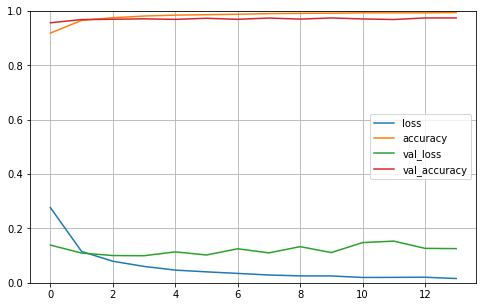

In [25]:
import pandas as pd

pd.DataFrame(treinamento.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Restringindo o Eixo y
plt.show()

Teste Inicial

In [26]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels, verbose=2)
print(f'\nResultado do Teste: {test_acc:.4f}')

313/313 - 0s - loss: 0.0953 - accuracy: 0.9741 - 456ms/epoch - 1ms/step

Resultado do Teste: 0.9741


O objetivo é 98%. Vamos modificar a rede.

#### 2.2 Otimizando a Rede

In [32]:
from keras_tuner.tuners import RandomSearch

def construir_modelo(hp):
    modelo = keras.Sequential()
    modelo.add(keras.layers.Flatten(input_shape = (28, 28)))
    
    unidades = hp.Int('Tamanho da Camada', min_value=32, max_value=512, step=32)
    ativacao = hp.Choice('Função de Ativação', values=["relu", "elu"])

    modelo.add(keras.layers.Dense(units=unidades, activation=ativacao))
    modelo.add(keras.layers.Dense(units=unidades, activation=ativacao))
    modelo.add(keras.layers.Dense(units=unidades, activation=ativacao))
    modelo.add(keras.layers.Dense(10, activation='softmax'))

    # Tune a taxa de aprendizado
    
    modelo.compile(optimizer="nadam",
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
    
    return modelo

Reduzindo a paciência

In [33]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
tuner = RandomSearch(
    construir_modelo,
    objective='val_accuracy',
    max_trials=10
)

tuner.search(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.9746666550636292

Best val_accuracy So Far: 0.9782500267028809
Total elapsed time: 00h 12m 23s


In [39]:
parametros = tuner.get_best_hyperparameters()[0]
print(parametros.get('Tamanho da Camada'))
print(parametros.get('Função de Ativação'))

512
relu


In [27]:
modelo = keras.Sequential()
modelo.add(keras.layers.Flatten(input_shape = (28, 28)))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(10, activation='softmax'))


In [28]:
modelo.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
treinamento = modelo.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2072 - accuracy: 0.9367 - val_loss: 0.1133 - val_accuracy: 0.9662
Epoch 2/100
1500/1500 [==============================] - 11s 8ms/step - loss: 0.0961 - accuracy: 0.9708 - val_loss: 0.1057 - val_accuracy: 0.9700
Epoch 3/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0682 - accuracy: 0.9794 - val_loss: 0.1055 - val_accuracy: 0.9698
Epoch 4/100
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0535 - accuracy: 0.9837 - val_loss: 0.1088 - val_accuracy: 0.9722
Epoch 5/100
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0932 - val_accuracy: 0.9745
Epoch 6/100
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0375 - accuracy: 0.9889 - val_loss: 0.0893 - val_accuracy: 0.9768
Epoch 7/100
1500/1500 [==============================] - 13s 8ms/step - loss: 0.0336 - accuracy: 0.9903 - val_loss: 0.1209 -

In [30]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels, verbose=2)
print(f'\nResultado do Teste: {test_acc:.4f}')

313/313 - 1s - loss: 0.0846 - accuracy: 0.9788 - 906ms/epoch - 3ms/step

Resultado do Teste: 0.9788


Testando outro otimizador

In [31]:
modelo = keras.Sequential()
modelo.add(keras.layers.Flatten(input_shape = (28, 28)))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(10, activation='softmax'))

modelo.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

treinamento = modelo.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2255 - accuracy: 0.9329 - val_loss: 0.1916 - val_accuracy: 0.9454
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1005 - accuracy: 0.9728 - val_loss: 0.1386 - val_accuracy: 0.9602
Epoch 3/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0770 - accuracy: 0.9790 - val_loss: 0.1295 - val_accuracy: 0.9722
Epoch 4/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0662 - accuracy: 0.9833 - val_loss: 0.1251 - val_accuracy: 0.9748
Epoch 5/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0499 - accuracy: 0.9869 - val_loss: 0.1205 - val_accuracy: 0.9778
Epoch 6/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0440 - accuracy: 0.9887 - val_loss: 0.1377 - val_accuracy: 0.9761
Epoch 7/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0376 - accuracy: 0.9908 - val_loss: 0.1447 - val_a

In [32]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels, verbose=2)
print(f'\nResultado do Teste: {test_acc:.4f}')

313/313 - 1s - loss: 0.1130 - accuracy: 0.9772 - 854ms/epoch - 3ms/step

Resultado do Teste: 0.9772


In [35]:
modelo = keras.Sequential()
modelo.add(keras.layers.Flatten(input_shape = (28, 28)))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(512, activation="relu"))
modelo.add(keras.layers.Dense(10, activation='softmax'))

modelo.compile(optimizer=keras.optimizers.SGD(learning_rate = 0.3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

treinamento = modelo.fit(train_images, train_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2892 - accuracy: 0.9122 - val_loss: 0.1160 - val_accuracy: 0.9641
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1061 - accuracy: 0.9668 - val_loss: 0.1171 - val_accuracy: 0.9648
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0701 - accuracy: 0.9778 - val_loss: 0.0966 - val_accuracy: 0.9741
Epoch 4/100
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0920 - val_accuracy: 0.9742
Epoch 5/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0928 - val_accuracy: 0.9758
Epoch 6/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.0871 - val_accuracy: 0.9778
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0847 - val_ac

In [36]:
test_loss, test_acc = modelo.evaluate(test_images, test_labels, verbose=2)
print(f'\nResultado do Teste: {test_acc:.4f}')

313/313 - 1s - loss: 0.0782 - accuracy: 0.9800 - 878ms/epoch - 3ms/step

Resultado do Teste: 0.9800
